In [1]:
import sys; sys.path.append('..'); from wwa import *

xn,xx,yn,yx = [27,41,-13,2]
mapproj = cartopy.crs.PlateCarree()

sf = gpd.read_file("sf")

# HighResMIP

## Extract data over the region

In [2]:
ml = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_Mariam/data/highresmip/*/pr/"))
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/"

In [ ]:
for mpath in ml:
    
    print(mpath.split("/")[-3])
    fl_hist = sorted(glob.glob(mpath+"*present*[0-9].nc"))
    fl_fut = sorted(glob.glob(mpath+"*future*[0-9].nc"))

    # filter file list to remove duplicated years
    last_hist = fl_hist[-1][-11:-3]
    fl_fut = [fnm for fnm in fl_fut if fnm[-20:-12] > last_hist]

    new_fnm = outpath + "pr_day_"+"_".join(fl_hist[0].split("_")[6:7]+fl_hist[0].split("_")[-3:-1])+".nc"
    
    if os.path.exists(new_fnm): continue
    da = xr.open_mfdataset(fl_hist + fl_fut).pr.sel(lon = slice(xn,xx), lat = slice(yn,yx))

    da.to_netcdf(new_fnm)
    
clear_output(wait = False)
print("Done.")

In [84]:
# time series, spatial & seasonal patterns
for fnm in glob.glob(outpath+"*.nc"):
    
    mdl = "_".join(fnm.split("_")[-3:-1])
    da = convert_units_to(xr.open_dataset(fnm).pr, "mm/day")
    
    if len(da.sel(time = slice("1990","2020")).time) == 0: continue
    
    # spatial pattern
    sp = da.resample(time = "QS-DEC").sum().groupby("time.season")["MAM"].sel(time = slice("1990", "2020")).mean("time")
    sp.to_netcdf("data/highresMIP/"+re.sub("day", "spatial", fnm.split("/")[-1]))
    
    # daily time series
    rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
    ts = da.where(rm == 0).mean(["lat", "lon"])
    
    # seasonal cycle
    sc = ts.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
    sc.to_netcdf("data/highresMIP/"+re.sub("day", "seasonal-cycle", fnm.split("/")[-1]))
    
    # create time series for Climate Explorer
    for ndays in [30,60]:
        
        rxnday = ts.rolling(time = ndays).sum().resample(time = "QS-DEC").max().groupby("time.season")["MAM"]
        rxnday = rxnday.assign_coords(time = rxnday.time.dt.year).rename(time = "year").to_dataframe()
        
        csv_fnm = "EA-floods_rx"+str(ndays)+"day_highresmip_"+mdl
        csv_fullpath = "ts/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
            
        # create extra header lines for upload to Climate Explorer 
        str1 = "# contact :: HighResMIP "+mdl+" MAM maxima of rx"+str(ndays)+"day - East Africa floods 2024, c.barnes22@imperial.ac.uk"
        str2 = "# rx"+str(ndays)+"day [mm] March-May maximum of "+str(ndays)+"-day accumulated precipitatio at "+csv_fnm+".dat"
        head = "# year rx"+str(ndays)+"day"

        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        rxnday.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

        clear_output(wait = False)

# Gridded observational products

In [7]:
# ds = "chirps"; da = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/precip_chirps_1981-2024_EA.nc")).precip.rename("pr", longitude = "lon", latitude = "lat")
# ds = "tamsat"; da = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/precip_tamsat_1983-2024_EA.nc")).rfe.rename("pr")
ds = "mswep"; da = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/MSWEP/mswep_EA_*.nc")).precipitation.rename("pr")
# ds = "cpc"; da = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/cpc/precip*.nc")).precip.rename("pr")

In [8]:
# Daily time series
rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
ts = da.where(rm == 0).mean(["lat", "lon"])
ts.to_netcdf("data/daily-ts_pr_"+ds+".nc")

In [12]:
# gridded n-day seasonal maxima over study region only
for ndays in [30, 60]:
    da = da.sel(lon = slice(xn,xx), lat = slice(yn,yx))
    rxnday = da.rolling(time = ndays, center = False).sum().resample(time = "QS-DEC").max().groupby("time.season")["MAM"]
    rxnday.to_netcdf("data/rx"+str(ndays)+"day-MAM_gridded_"+ds+".nc")

## Time series for climate explorer

In [13]:
datasets = ["cpc", "mswep", "chirps", "tamsat"]
for ndays in [30,60]:
    for ds in datasets:

        ts = xr.open_dataset("data/daily-ts_pr_"+ds+".nc").pr
        ts = ts.rolling(time = ndays, center = False).sum().resample(time = "QS-JAN").max().groupby("time.season")["MAM"]
        ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

        csv_fnm = "EA-floods_rx"+str(ndays)+"day_obs_"+ds
        csv_fullpath = "ts/"+csv_fnm+".dat"

        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        # create extra header lines for upload to Climate Explorer 
        str1 = "# contact :: "+ds.upper()+" MAM maxima of rx"+str(ndays)+"day - East Africa floods 2024, c.barnes22@imperial.ac.uk"
        str2 = "# rx"+str(ndays)+"day [mm] March-May maximum of "+str(ndays)+"-day accumulated precipitatio at "+csv_fnm+".dat"
        head = "# year rx"+str(ndays)+"day"

        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

        clear_output(wait = False)

# Covariates

## MAM IOD

In [45]:
iod = decode_times(xr.open_dataset("data/idmi_ersst.nc", decode_times = False))["diff"].rename("IOD")

iod_mam = iod.resample(time = "QS-DEC").mean().groupby("time.season")["MAM"]
iod_mam = iod_mam.assign_coords(time = iod_mam.time.dt.year).rename(time = "year").to_dataframe()
ts = iod_mam

In [29]:
csv_fnm = "EA-floods_iod-mam_obs_ersst"
csv_fullpath = "ts/"+csv_fnm+".dat"

if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: MAM IOD (ERSST) - East Africa floods 2024, c.barnes22@imperial.ac.uk"
str2 = "# iod [degC] March-May mean of IOD at "+csv_fnm+".dat"
head = "# year iod"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
iod_mam.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

## DJF detrended Nino3.4

In [48]:
nino = xr.open_dataset("../10_misc/detrended_nino34/ersst_nino34_detrended.nc").nino34
nino_djf = nino.resample(time = "QS-DEC").mean().groupby("time.season")["DJF"]
nino_djf = nino_djf.assign_coords(time = nino_djf.time.dt.year + 1).rename(time = "year").to_dataframe()
ts = nino_djf

csv_fnm = "EA-floods_nino-djf_obs_ersst"
csv_fullpath = "ts/"+csv_fnm+".dat"

if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: DJF detrended Nino3.4 (ERSST) - East Africa floods 2024, c.barnes22@imperial.ac.uk"
str2 = "# nino [degC] December-February mean of Nino3.4 detrended by subtracting mean of tropical SSTs at "+csv_fnm+".dat"
head = "# year nino"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

# MSWEP missing data?

In [2]:
mswep_path = "/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswep_past/"
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/MSWEP/"
for y in ["1984","1994","2011"]:
    fl = sorted(glob.glob(mswep_path+y+"*"))
    da = xr.open_mfdataset(fl)
    da = wrap_lon(da).sel(lon = slice(26,50), lat = slice(-12,8))
    da.to_netcdf(outpath+"mswep_EA_"+y+".nc")

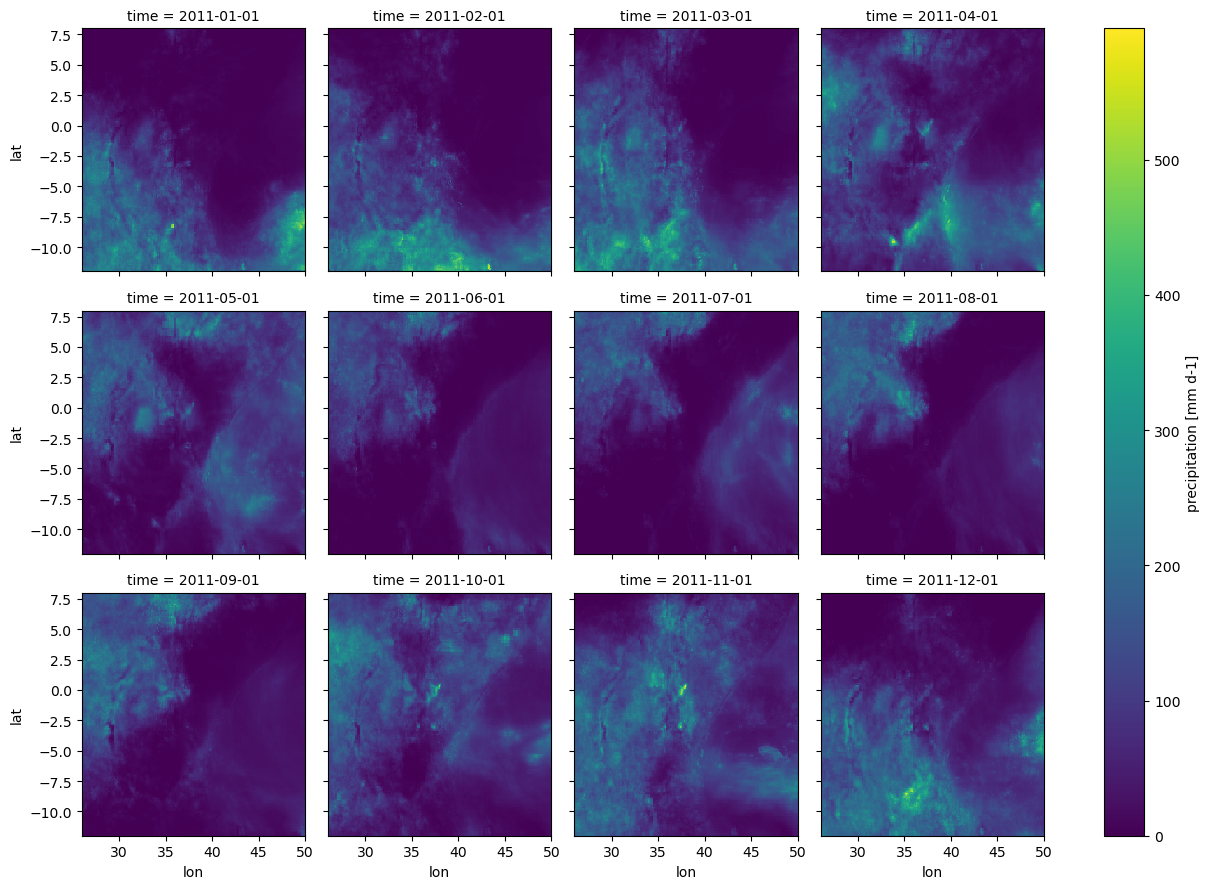

In [6]:
da.precipitation.resample(time = "MS").sum().plot(col = "time", col_wrap = 4)